# RFSoC Spectrum Analyser

This notebook utilises ADC_C as a spectrum analyser with a sampling frequency of 4423.68 MHz. The maximum frequency of the spectrum (Nyquist-Shannon sampling theorem) is therefore 2211.84 MHz. The multi-rate buffer is used as it is the only buffer which may store non-downsampled ADC data.

If the parameter `mode = "periodic"` is passed when calling the `prog.set_pulse_registers()` function, the DAC will continue to generate the given waveform indefinitely. This spectrum analyser notebook may then be run while the DACs are generating a waveform. Alternatively, the ADC code may be integrated into a program with the DAC for dynamic readout.

In [81]:
# Import libraries
%load_ext autoreload
%autoreload 2

from scipy.signal import welch

from qick import *
import Pyro4
import pickle
%pylab inline

# Pyro communicates with board
Pyro4.config.SERIALIZER = "pickle"
Pyro4.config.PICKLE_PROTOCOL_VERSION=4

# Static IP proxy
ns_host = "172.24.106.21"
ns_port = 8888
proxy_name = "myqick"

# QICK object
ns = Pyro4.locateNS(host=ns_host, port=ns_port)
soc = Pyro4.Proxy(ns.lookup(proxy_name))
soccfg = QickConfig(soc.get_cfg())
print(soccfg)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib

QICK configuration:

	Board: RFSoC4x2

	Software version: 0.2.267
	Firmware timestamp: Wed Sep  6 18:49:29 2023

	Global clocks (MHz): tProcessor 409.600, RF reference 491.520

	2 signal generator channels:
	0:	axis_signal_gen_v6 - envelope memory 65536 samples (6.667 us)
		fs=9830.400 MHz, fabric=614.400 MHz, 32-bit DDS, range=9830.400 MHz
		DAC tile 0, blk 0 is DAC_B
	1:	axis_signal_gen_v6 - envelope memory 65536 samples (6.667 us)
		fs=9830.400 MHz, fabric=614.400 MHz, 32-bit DDS, range=9830.400 MHz
		DAC tile 2, blk 0 is DAC_A

	2 readout channels:
	0:	axis_readout_v2 - configured by PYNQ
		fs=4423.680 MHz, decimated=552.960 MHz, 32-bit DDS, range=4423.680 MHz
		maxlen 16384 accumulated, 1024 decimated (1.852 us)
		triggered by output 7, pin 14, feedback

c:\Users\micro\qeg-rfsoc\.venv\lib\site-packages\IPython\core\magics\pylab.py:162: UserWarning: pylab import has clobbered these variables: ['psd']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [238]:
# Produce signal for loopback
freq = 1000 # [MHz.]
gain = 30000 # [arb.]

# Reset DACs
soc.reset_gens()

# Program DAC registers
prog = QickProgram(soccfg)
for ch in range(2): 
    prog.declare_gen(ch=ch, nqz=1) # Initialise DACs
    prog.set_pulse_registers(ch = ch,
                             gain = gain, # SSB gains
                             freq = prog.freq2reg(freq, gen_ch=ch),
                             phase = prog.deg2reg(0, gen_ch=ch),
                             style = "const",
                             length = prog.us2cycles(100, gen_ch=ch),
                             mode = "periodic", # Constant output
                            )
    prog.pulse(ch=ch, t=0) # Trigger DAC

# Start DACs
prog.config_all(soc) # Configure for internal start
soc.tproc.start() # Internal start
# print(prog)

In [235]:
# Spectrum analyser program
prog = QickProgram(soccfg) # Intitialse program class

prog.declare_readout(ch=1, length=1000, freq=0, gen_ch=1, sel="input") # Declare ADC_C as a readout
prog.trigger(mr=True) # Trigger the multi-rate buffer

prog.config_all(soc) # Load the assembly onto the board
soc.arm_mr(ch=1) # Arm the multi-rate buffer
soc.tproc.start() # Start tproc program execution

8184 samples


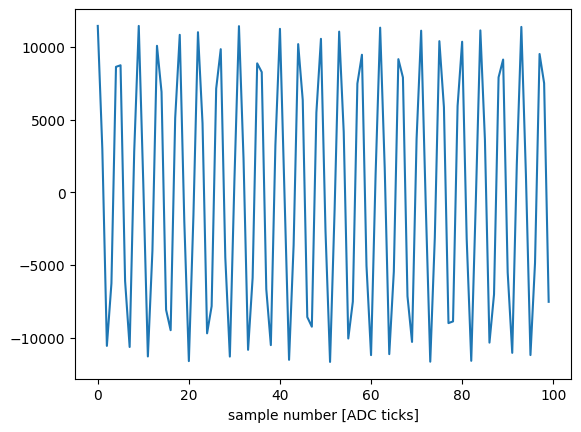

In [236]:
# Get sampled data from multi-rate buffer
iq_mr = soc.get_mr()

print(f"{len(iq_mr[:,0])} samples")

# Plot sampled data
plt.plot(iq_mr[0:100,0])
plt.xlabel("sample number [ADC ticks]")
plt.show()

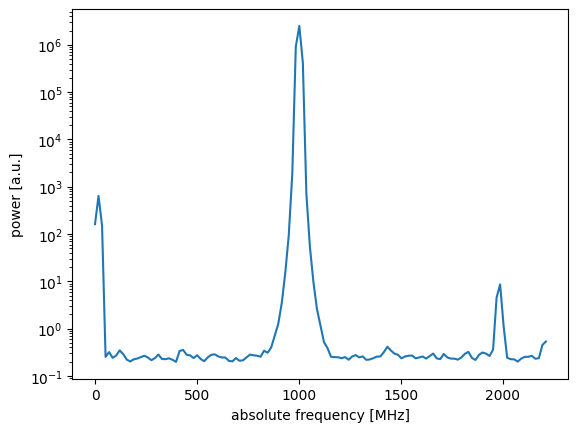

In [237]:
# Get sampling frequency and compute power spectral density of data
fs_adc = soccfg['readouts'][1]['fs']
fft_freqs, psd = welch(iq_mr[:,0], fs_adc, return_onesided=True, detrend=False, nperseg=256)

# Plot psd as function of frequency
plt.semilogy(fft_freqs, psd)
plt.xlabel("absolute frequency [MHz]")
plt.ylabel("power [a.u.]");
plt.show()

# Optionally print frequency aligned with maximum power density
# print("Frequency:", fft_freqs[argmax(psd)], "MHz")

In [239]:
# Stop the DACs
soc.reset_gens()